## **Tutorial: Flower Image Prediction
1. Getting image data in, preprocessing it, and fitting a model



In [5]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3




In [6]:
# Importing images from tensorflow compressed tgz file and saving them to folder

FLOWERS_DIR="flower_photos" # downloading to this directory drom the download url
def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


import os
from six.moves import urllib


# Download the images to flower_photos folder
download_images()

Flower photos are located in flower_photos


In [9]:
# Extracting all filenames iteratively
base_path = 'flower_photos'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# load file names to fnames list object
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [633, 898, 641, 699, 799]
[['flower_photos/daisy/9467543719_c4800becbb_m.jpg', 'flower_photos/daisy/15207766_fc2f1d692c_n.jpg', 'flower_photos/daisy/3336704121_cfeb67a7d7.jpg', 'flower_photos/daisy/4757448834_a29a9538c9_n.jpg', 'flower_photos/daisy/3463313493_9497aa47e5_n.jpg', 'flower_photos/daisy/3598615130_578ed30e5f.jpg', 'flower_photos/daisy/14264136211_9531fbc144.jpg', 'flower_photos/daisy/9595857626_979c45e5bf_n.jpg', 'flower_photos/daisy/7630520686_e3a61ac763.jpg', 'flower_photos/daisy/7227973870_806d9d3e42_n.jpg', 'flower_photos/daisy/4668543441_79040ca329_n.jpg', 'flower_photos/daisy/506493250_e9ca42fe3d.jpg', 'flower_photos/daisy/6910811638_aa6f17df23.jpg', 'flower_photos/daisy/6480809771_b1e14c5cc2_m.jpg', 'flower_photos/daisy/2538504987_fe524b92a8_n.jpg', 'flower_photos/daisy/2862944799_45bc8e7302.jpg', 'flower_photos/daisy/3750250718_eb61146c5f.jpg', 'flower_photos/daisy/14551098743_2842e7a004_n.jpg', 'flower_photos/daisy/14073784469_ff

In [10]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (192,192)) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('flower_photos/daisy/11642632_1e7627a2cc.jpg')


array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [11]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
flower_filepaths = fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data = list(map(preprocessor,flower_filepaths))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X = np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [12]:
X.shape #Imported 3670 observations

(3670, 192, 192, 3)

In [13]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

3670
(192, 192, 3)
0.0
1.0


(3670, 192, 192, 3)

In [14]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each 
# folder corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
daisy = list(repeat("daisy", 633))
dandelion = list(repeat("dandelion", 898))
roses = list(repeat("roses", 641))
sunflowers = list(repeat("sunflowers", 699))
tulips = list(repeat("tulips", 799))

#combine into single list of y labels
y_labels = daisy + dandelion + roses + sunflowers + tulips

#check length, same as X above
len(y_labels) 

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y = pd.get_dummies(y_labels)

display(y)

number of images for each category: [633, 898, 641, 699, 799]


,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
3665,0,0,0,0,1
3666,0,0,0,0,1
3667,0,0,0,0,1
3668,0,0,0,0,1


In [25]:
X[0].shape

(192, 192, 3)

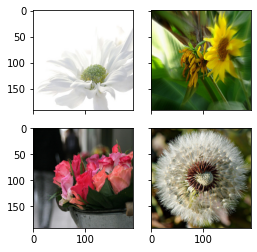

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 = preprocessor('flower_photos/daisy/11642632_1e7627a2cc.jpg')
im2 = preprocessor('flower_photos/sunflowers/5556633113_0a04f5ed8a_n.jpg')
im3 = preprocessor('flower_photos/roses/3052753519_d087aaeacb_n.jpg')
im4 = preprocessor('flower_photos/dandelion/2019520447_48b2354a20_m.jpg')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()
        

In [15]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_train 

,daisy,dandelion,roses,sunflowers,tulips
1997,0,0,1,0,0
1875,0,0,1,0,0
2840,0,0,0,1,0
2631,0,0,0,1,0
1605,0,0,1,0,0
...,...,...,...,...,...
3484,0,0,0,0,1
1634,0,0,1,0,0
1741,0,0,1,0,0
1689,0,0,1,0,0


In [28]:
X_train.shape

(2936, 192, 192, 3)

## Back to example code for Keras Convolutional Neural Net:

In [31]:
# Let's set a baseline plain vanilla network model to use as a baseline for convnet models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(learning_rate=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(5, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
92/92 [==============================] - 12s 124ms/step - loss: 1.4971 - accuracy: 0.3369 - val_loss: 1.4357 - val_accuracy: 0.3501
Epoch 2/5
92/92 [==============================] - 11s 119ms/step - loss: 1.3224 - accuracy: 0.4418 - val_loss: 1.3073 - val_accuracy: 0.4659
Epoch 3/5
92/92 [==============================] - 11s 118ms/step - loss: 1.2396 - accuracy: 0.4816 - val_loss: 1.2724 - val_accuracy: 0.4455
Epoch 4/5
92/92 [==============================] - 11s 118ms/step - loss: 1.1905 - accuracy: 0.5167 - val_loss: 1.2780 - val_accuracy: 0.4292
Epoch 5/5
92/92 [==============================] - 11s 118ms/step - loss: 1.1636 - accuracy: 0.5290 - val_loss: 1.2338 - val_accuracy: 0.4564


{'name': 'SGD', 'learning_rate': 0.001, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
{'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_4_input'}}, {'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer'

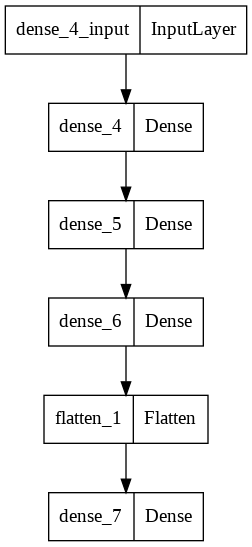

In [32]:
import tensorflow.keras.backend as K

print(K.eval(model.optimizer.get_config()))

print(model.get_config())

print(len(model.history.epoch))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [34]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
    optimizer="adam", 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) 

Epoch 1/5
92/92 [==============================] - 19s 91ms/step - loss: 1.4160 - accuracy: 0.3678 - val_loss: 1.2906 - val_accuracy: 0.4537
Epoch 2/5
92/92 [==============================] - 5s 55ms/step - loss: 1.1601 - accuracy: 0.5065 - val_loss: 1.1623 - val_accuracy: 0.5027
Epoch 3/5
92/92 [==============================] - 5s 55ms/step - loss: 1.0684 - accuracy: 0.5616 - val_loss: 1.1006 - val_accuracy: 0.5123
Epoch 4/5
92/92 [==============================] - 5s 55ms/step - loss: 1.0380 - accuracy: 0.5875 - val_loss: 1.0045 - val_accuracy: 0.6117
Epoch 5/5
92/92 [==============================] - 5s 55ms/step - loss: 0.9578 - accuracy: 0.6287 - val_loss: 0.9240 - val_accuracy: 0.6322


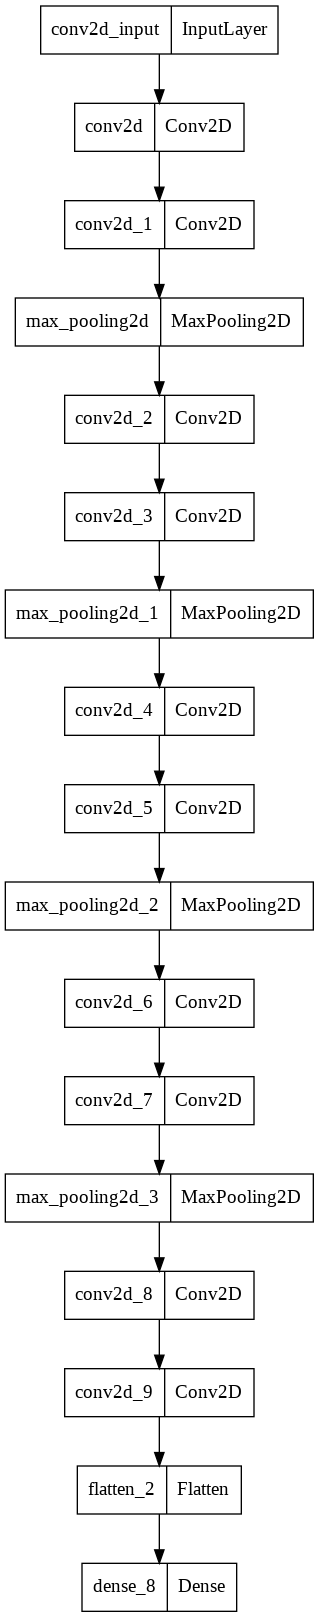

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# Let's build a squeezenet model instead to see how well it performs 
# Does adding more layers help (i.e.- try building a deeper and deeper network)

l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
            x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(5, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            model = tf.keras.Model(x, y)
        
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
        
            model.fit(X_train, 
                      y_train, 
                      epochs=5, 
                      verbose=1,
                      validation_data=(X_test,y_test)
                      )

Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 11s 4ms/sample - loss: 1.4982 - acc: 0.3386 - val_loss: 1.3259 - val_acc: 0.4605
Epoch 2/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 1.3035 - acc: 0.4469 - val_loss: 1.2320 - val_acc: 0.4196
Epoch 3/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 1.2634 - acc: 0.4465 - val_loss: 1.1920 - val_acc: 0.5041
Epoch 4/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 1.2221 - acc: 0.4959 - val_loss: 1.2011 - val_acc: 0.4809
Epoch 5/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 1.1968 - acc: 0.4911 - val_loss: 1.2196 - val_acc: 0.4768


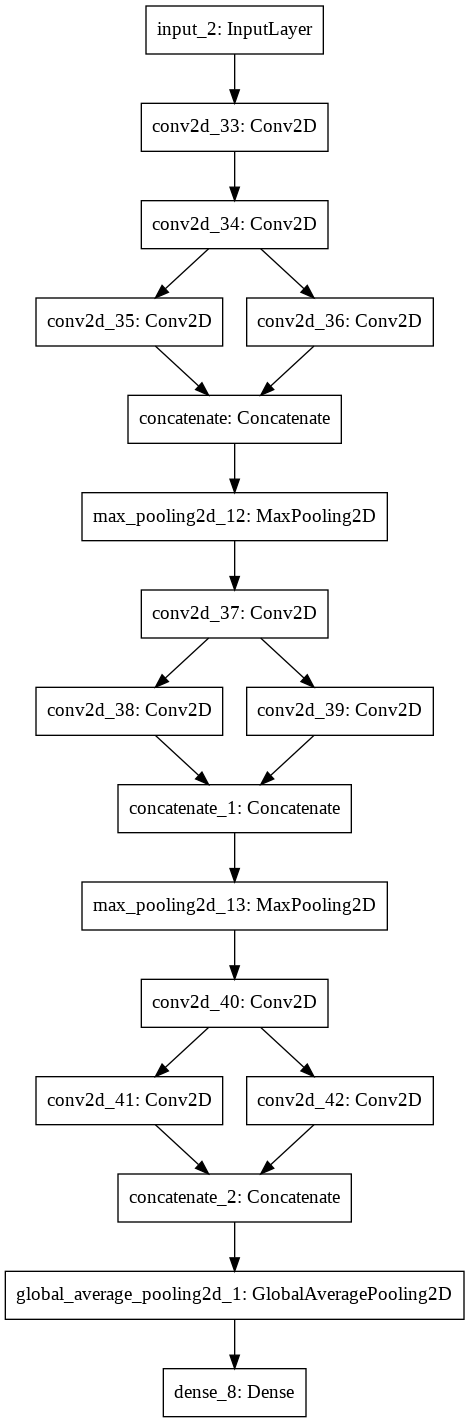

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# visualize the shallow network we created that uses fire modules


x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(5, activation='softmax')(y)

model = tf.keras.Model(x, y)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 192, 192, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 192, 192, 24) 792         conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 192, 192, 24) 600         conv2d_44[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Adding batch normalization to assist with optimization for deeper network

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(72, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(96, 512)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(5, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 21s 7ms/sample - loss: 1.1253 - acc: 0.5763 - val_loss: 2.5522 - val_acc: 0.2262
Epoch 2/5
2936/2936 [==============================] - 17s 6ms/sample - loss: 0.8564 - acc: 0.6706 - val_loss: 3.1510 - val_acc: 0.2262
Epoch 3/5
2936/2936 [==============================] - 18s 6ms/sample - loss: 0.7585 - acc: 0.7197 - val_loss: 3.6622 - val_acc: 0.2262
Epoch 4/5
2936/2936 [==============================] - 18s 6ms/sample - loss: 0.7257 - acc: 0.7245 - val_loss: 2.2372 - val_acc: 0.3392
Epoch 5/5
2936/2936 [==============================] - 18s 6ms/sample - loss: 0.6772 - acc: 0.7503 - val_loss: 1.2180 - val_acc: 0.5436


## Transfer Learning: Start with pre-established weights and retrain model final output layer to fit new output layer parameters to your data.

Different ways we might use a pretrained model:

1.   The pre-trained model is used directly to classify new images.
2.   The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during training. 
3.   Weight Initialization: The pre-trained model, or some portion of the model, is integrated into a new model, and the layers of the pre-trained model are trained in concert with the new model. Takes more computational power b/c we are fitting complete model (i.e.-VGGNet has lots of parameters to train!)




In [1]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [2]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [3]:

# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model
  
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [16]:

# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 3, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/3
2933/2936 [============================>.] - ETA: 0s - loss: 1.6213 - acc: 0.2666
Epoch 00001: val_acc improved from -inf to 0.30926, saving model to best_model.h5
2936/2936 [==============================] - 50s 14ms/step - loss: 1.6213 - acc: 0.2667 - val_loss: 1.4990 - val_acc: 0.3093 - lr: 0.0100
Epoch 2/3
2935/2936 [============================>.] - ETA: 0s - loss: 1.4168 - acc: 0.3894
Epoch 00002: val_acc improved from 0.30926 to 0.48229, saving model to best_model.h5
2936/2936 [==============================] - 40s 14ms/step - loss: 1.4163 - acc: 0.3896 - val_loss: 1.2020 - val_acc: 0.4823 - lr: 0.0100
Epoch 3/3
2933/2936 [============================>.] - ETA: 0s - loss: 1.2869 - acc: 0.4586
Epoch 00003: val_acc did not improve from 0.48229
2936/2936 [==============================] - 40s 14ms/step - loss: 1.2872 - acc: 0.4584 - val_loss: 1.5133 - val_acc: 0.3256 - lr: 0.0100


In [17]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01]
2


In [ ]:
# example of loading a version of the Resnet Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
__________________________

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input


# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(5, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()




Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Fit Resnet model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/10
2936/2936 [==============================] - 12s 4ms/sample - loss: 0.0767 - acc: 0.9816 - val_loss: 2.4380 - val_acc: 0.1485
Epoch 2/10
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.0774 - acc: 0.9819 - val_loss: 2.4365 - val_acc: 0.1553
Epoch 3/10
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.0649 - acc: 0.9874 - val_loss: 2.4230 - val_acc: 0.1580
Epoch 4/10
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.0718 - acc: 0.9847 - val_loss: 2.4605 - val_acc: 0.1567
Epoch 5/10
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.0685 - acc: 0.9850 - val_loss: 2.4391 - val_acc: 0.1553
Epoch 6/10
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.0694 - acc: 0.9823 - val_loss: 2.4525 - val_acc: 0.1580
Epoch 7/10
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.0593 - acc: 0.9891 - val_loss: 2.4491 - val_acc: 0

## Plenty of trainable models we can use taking same approach:
## See all here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

### **Next example - Inception model with same approach to transfer learning as above:**

In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_351 (Conv2D)             (None, 95, 95, 32)   864         input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_297 (BatchN (None, 95, 95, 32)   96          conv2d_351[0][0]                 
__________________________________________________________________________________________________
activation_297 (Activation)     (None, 95, 95, 32)   0           batch_normalization_297[0][0]    
________________________________________________________________________________

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 95, 95, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_219 (BatchN (None, 95, 95, 32)   96          conv2d_275[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_219[0][0]    
________________________________________________________________________________

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(5, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 12s 4ms/sample - loss: 0.7302 - acc: 0.7405 - val_loss: 2.0149 - val_acc: 0.2452
Epoch 2/5
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.3782 - acc: 0.8566 - val_loss: 2.0110 - val_acc: 0.2466
Epoch 3/5
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.2942 - acc: 0.8999 - val_loss: 2.0425 - val_acc: 0.2316
Epoch 4/5
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.2572 - acc: 0.9084 - val_loss: 2.0830 - val_acc: 0.2384
Epoch 5/5
2936/2936 [==============================] - 10s 3ms/sample - loss: 0.2147 - acc: 0.9336 - val_loss: 2.2485 - val_acc: 0.2425


## What if we unfreeze some of the layers from the inception model?

In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_257 (Conv2D)             (None, 95, 95, 32)   864         input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 95, 95, 32)   96          conv2d_257[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_203[0][0]    
______________________

In [ ]:
len(base_model.trainable_variables) #488 trainable layers


188

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)


Number of layers in the base model:  311
Number of layers frozen in the base model:  301


In [ ]:
len(base_model.trainable_variables) #6 trainable layers after freezing

6

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(5, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_257 (Conv2D)             (None, 95, 95, 32)   864         input_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 95, 95, 32)   96          conv2d_257[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_203[0][0]    
___________________________________________________________________________________________

In [ ]:
# Fit Inception model with some unfrozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 23s 8ms/sample - loss: 0.7042 - acc: 0.7578 - val_loss: 1.6355 - val_acc: 0.5736
Epoch 2/5
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.5729 - acc: 0.7980 - val_loss: 1.5701 - val_acc: 0.5981
Epoch 3/5
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.5247 - acc: 0.8208 - val_loss: 1.8693 - val_acc: 0.6063
Epoch 4/5
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.4676 - acc: 0.8467 - val_loss: 1.7354 - val_acc: 0.6117
Epoch 5/5
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.4346 - acc: 0.8423 - val_loss: 1.2590 - val_acc: 0.7003
